# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from numpy.random import RandomState

import warnings
warnings.filterwarnings("ignore")

import scipy.stats as st

In [2]:
df_1 = pd.read_csv('/datasets/geo_data_0.csv')
df_2 = pd.read_csv('/datasets/geo_data_1.csv')
df_3 = pd.read_csv('/datasets/geo_data_2.csv')

Напишем функцию для отображения общей информации по каждому датасету.

In [3]:
def info(data):
    print('Размер:', data.shape)
    print('Количество пропусков', data.isna().sum().sum())
    print('Количество дубликатов:', data.duplicated().sum())
    print('Количество нулей:', data[data['product'] == 0]['product'].count())
    print('Распределение целевого признака:', data['product'].hist(bins = 50, figsize = (12,8)))
    plt.show()

Размер: (100000, 5)
Количество пропусков 0
Количество дубликатов: 0
Количество нулей: 1
Распределение целевого признака: AxesSubplot(0.125,0.125;0.775x0.755)


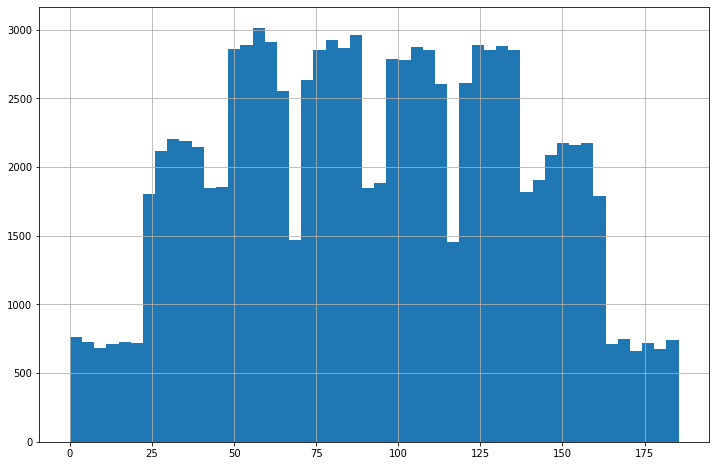

In [4]:
info(df_1)

Размер: (100000, 5)
Количество пропусков 0
Количество дубликатов: 0
Количество нулей: 8235
Распределение целевого признака: AxesSubplot(0.125,0.125;0.775x0.755)


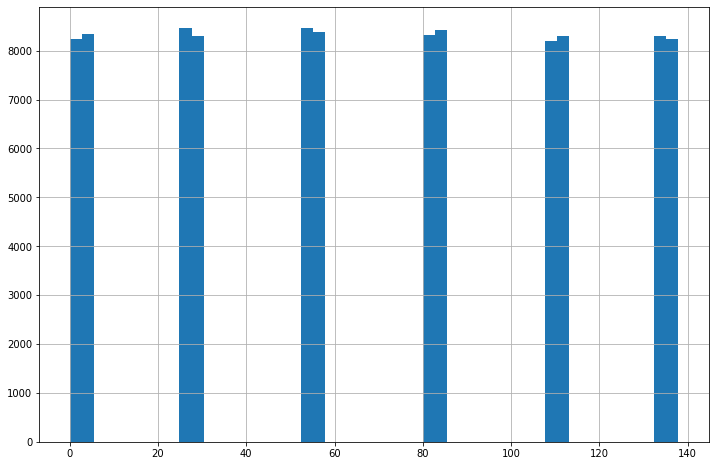

In [5]:
info(df_2)

Размер: (100000, 5)
Количество пропусков 0
Количество дубликатов: 0
Количество нулей: 1
Распределение целевого признака: AxesSubplot(0.125,0.125;0.775x0.755)


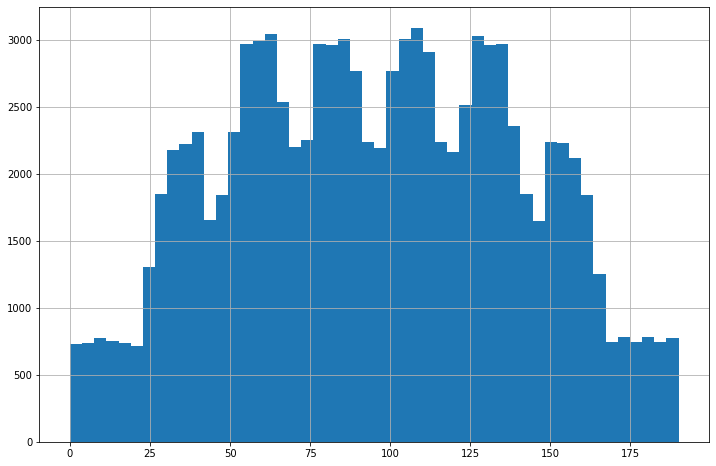

In [6]:
info(df_3)

<b>Вывод: </b>
1. Во всех трех датафреймах отсутствуют дубликаты и пропуски;
2. Столбец id не несет ценности для обучения модели;
3. Целевой признак нулевого и второго региона имеют нормальное распределение. Целевой признак первого региона имеет странное распределение с равномерным шагом. Распределение не подчиняется центральной предельной теореме;
4. В датасете второго месторождеиня в целевом признаке присутствует большое количество нулей. Примерно 8.25% от всего столбца.

## Обучение и проверка модели

In [7]:
def split(data):
    features = data.drop(columns = ['id', 'product'])
    target = data['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target, 
                                                                                  test_size = 0.25, 
                                                                                  random_state = 2077)
    
    scaler = StandardScaler()
    scaler.fit(features_train)

    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)
   
    lr = LinearRegression(n_jobs = -1)
    lr.fit(features_train, target_train)
    predictions = lr.predict(features_valid)
    predictions = pd.Series(predictions)

    rmse = (mean_squared_error(predictions, target_valid)) ** 0.5
    reserve = predictions.mean()
    real = target_valid.mean()
    
    print('RMSE:', rmse)
    print('Средний запас предсказанного сырья', reserve, 'тыс. аррелей')
    print('Средний запас реального количества сырья', real, 'тыс. баррелей')
    print('\n')
    return predictions, target_valid.reset_index(drop=True)

In [8]:
print('Region 1')
predictions_1, target_valid_1 = split(df_1)
print('Region 2')
predictions_2, target_valid_2 = split(df_2)
print('Region 3')
predictions_3, target_valid_3 = split(df_3)

Region 1
RMSE: 37.63652870074733
Средний запас предсказанного сырья 92.64529632027816 тыс. аррелей
Средний запас реального количества сырья 92.58077388596652 тыс. баррелей


Region 2
RMSE: 0.8921603078868543
Средний запас предсказанного сырья 69.00507454037033 тыс. аррелей
Средний запас реального количества сырья 69.0026371946015 тыс. баррелей


Region 3
RMSE: 39.95484117214548
Средний запас предсказанного сырья 94.8849450288683 тыс. аррелей
Средний запас реального количества сырья 95.35178403695379 тыс. баррелей




<b>Вывод: </b>
1. Лучший результат по метрике качества RMSE модель показала на датасете первого региона - примерно 0.9 тыс. баррелей; Возможно, из-за большого количества нулей и необычного распределения, модель было легче предсказывать значения, и это положительно сказалось на качестве.  
2. Во втором регионе запас сырья =  69 тыс. баррелей, а в первом и третьем - 92 и 94 соответственно, что больше более чем в 1,5 раза;

## Подготовка к расчёту прибыли

<ul>
 <li>Один баррель сырья приносит 450 рублей дохода;</li>
 <li>Бюджет на разработку месторождений — 10 млрд рублей, стоимость бурения одной скважины — 50 млн рублей;</li>
</ul>

In [9]:
#Константы 
BUDGET = 1e+10 # Бюджет на разработку скважин в регионе ;
BARREL = 450 
BEST_POINTS = 200
CHOSEN_POINTS = 500

In [10]:
min = 50000000 / BARREL / 1000
print(f'Минимальный средний объём сырья: {min:.3f} тыс.баррелей для одной скважины')

Минимальный средний объём сырья: 111.111 тыс.баррелей для одной скважины


In [11]:
print(f'Средний объем нефти на регион: {BUDGET / BARREL / 1000:.1f} тыс.баррелей')

Средний объем нефти на регион: 22222.2 тыс.баррелей


<b>Вывод:</b><br>
    Средний запас сырья в скважинах меньше, чем точка безубыточности.

In [12]:
def calculation(target, probabilities, count):
    sort = probabilities.sort_values(ascending = False)
    selected = target[sort.index][:count]
    return (BARREL * 1000 * selected.sum() - BUDGET) / 1e9

## Риски и прибыль

In [13]:
state = RandomState(2077)

In [14]:
def distribution_revenue(target, probabilities):
    values = []
    for i in range(1000):
        target_subsample = target.sample(n = CHOSEN_POINTS, replace = True, random_state = state)
        probs_subsample = probabilities[target_subsample.index]
        values.append(calculation(target_subsample, probs_subsample, 200))
    values = pd.Series(values)
    mean = values.mean()
    print(f'Средняя прибыль {mean:.2f} млрд.руб.')
    
    lower = np.quantile(values, 0.025)
    upper = np.quantile(values, 0.975)
    print(f'95%-й доверительный интервал {lower} - {upper} млрд.руб.')
    
    loss_risk = st.percentileofscore(values, 0)
    print(f'Риск убытков {loss_risk} %')
    return values.hist()

<b>Регион 1</b>

Средняя прибыль 0.43 млрд.руб.
95%-й доверительный интервал -0.08509296860359836 - 0.9328743513708473 млрд.руб.
Риск убытков 4.9 %


<AxesSubplot:>

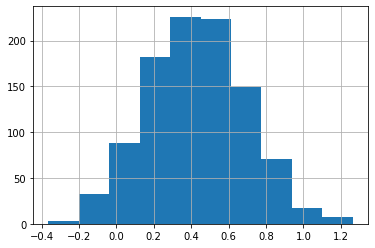

In [15]:
distribution_revenue(target_valid_1, predictions_1)

<b>Регион 2</b>

Средняя прибыль 0.52 млрд.руб.
95%-й доверительный интервал 0.13159864711032354 - 0.9030631776661412 млрд.руб.
Риск убытков 0.4 %


<AxesSubplot:>

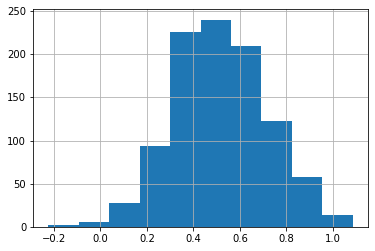

In [16]:
distribution_revenue(target_valid_2, predictions_2)

<b>Регион 3</b>

Средняя прибыль 0.46 млрд.руб.
95%-й доверительный интервал -0.08356674493439492 - 0.9820240354111603 млрд.руб.
Риск убытков 4.7 %


<AxesSubplot:>

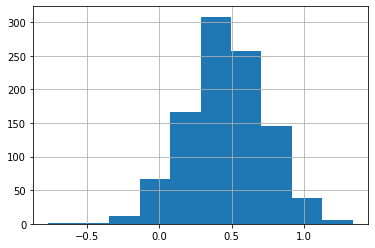

In [17]:
distribution_revenue(target_valid_3, predictions_3)

<b>Вывод:</b>
1. При Boostrap в 1000 выборок, конечная генеральная совокупность всех трех регионов имеет нормальное распределение. Средняя прибыль с трех регионов составляет 10.4 млрд.рублей;
2. Самым прибыльным регионом является второй. Также второй регион имеет наименьший процент риска убытков;
3. Второй регион является единственным, у которого 95%-доверительный интервал переваиливает за 10 млрд.

<b>Общий вывод:</b>
1. Обученая модель линейной регрессии показала, что во втором регионе наименьший показатель RMSE;
2. Для получения наибольшеq прибыли с наименьшими рисками добывающей компании «ГлавРосГосНефть» следует вложиться в развитие второго региона.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован